In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
import open3d as o3d
from sc3D import Embryo

with open('data/corresptissues.json') as f:
    corres_tissues = json.load(f)
    corres_tissues = {eval(k): v for k, v in corres_tissues.items()}
with open('data/tissuescolor.json') as f:
    colors_paper = json.load(f)
    colors_paper = {eval(k): v for k, v in colors_paper.items()}
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Setting up parameters

In [2]:
# Path to the input data
data_path = 'data/E8.5.h5ad'
# Path to the output folder
output_folder = 'out/'
import os
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Set of genes that will be interpolated
# genes_of_interest = ['Actb', 'T', 'Cdx2',
#                      'Fgf8','Mesp2', 'Tbx6', 'Meox1',
#                      'Uncx','Tbx18', 'Sox2', 'Nkx6-2',
#                      'Sox1', 'Otx2','Tnnt2', 'Shh',
#                      'Foxa2', 'Sox17', 'Gapdh']

genes_of_interest = ['T','Sox2']

# List of tissues that are ignored to do coverslip registration
tissues_to_ignore = [13, 15, 16, 22, 27, 29, 32, 36, 40, 41]

# Coverslips to ignore
# on the starting side
nb_CS_begin_ignore = 0
# on the ending side
nb_CS_end_ignore = 2

# Gives more weight to some tissues to help the alignment
tissue_weight = {31:2000}
# xy resolution
xy_resolution = .6
# Distance max that two beads can be linked together between coverslips
th_d = 150
# Threshold bellow which the beads will be considered noise.
# Value between 0 (all beads taken) and 1 (almost no beads taken)
outlier_threshold = .6

# Number of interpolated layers between two consecutive coverslips
nb_interp = 5

In [3]:
embryo = Embryo(data_path, tissues_to_ignore, corres_tissues, tissue_weight=tissue_weight,
                xy_resolution=xy_resolution, genes_of_interest=genes_of_interest,
                nb_CS_begin_ignore=nb_CS_begin_ignore, nb_CS_end_ignore=nb_CS_end_ignore,
                store_anndata=True)
embryo.removing_spatial_outliers(th=outlier_threshold)
embryo.reconstruct_intermediate(embryo, th_d=th_d, genes=genes_of_interest)

# Build point clouds

## Grey point cloud

In [4]:
# ploting all the tissues
# if one wants to plot a subset the list below can be uncomented and changed
# tissues_to_plot = [1, 2, 3, 4]
tissues_to_plot = embryo.all_tissues

# Creates the interpolation
points, colors = embryo.produce_em(nb_interp, tissues_to_plot)

# Create the pointcloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector([[.8,.8,.8],]*len(points))

# Saving the pointcloud
o3d.io.write_point_cloud("out/grey.ply", pcd)


True

## Tissue colored point cloud

In [5]:
# individual ploting a subset of tissues with the tissue color
# one wants to plot a subset the list below can be uncomented
# tissues_to_plot = embryo.all_tissues
tissues_to_plot = [18, 21, 30, 31, 34]

for t in tissues_to_plot:
    tissues_to_plot = [t]
    points, colors = embryo.produce_em(nb_interp, tissues_to_plot)
    if len(colors)<1:
        continue
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector([colors_paper[ci] for ci in colors])

    o3d.io.write_point_cloud(f"out/{corres_tissues[t]}.ply", pcd)

In [6]:
# individual ploting a subset of tissues with the tissue color
# one wants to plot a subset the list below can be uncomented
# tissues_to_plot = embryo.all_tissues
tissues_to_plot = [18, 21, 30, 31, 34]

points, colors = embryo.produce_em(nb_interp, tissues_to_plot)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector([colors_paper[ci] for ci in colors])

o3d.io.write_point_cloud(f"out/few_tissues.ply", pcd)

True

## Gene expression colored point clouds

In [7]:
# List of genes to plot
# genes_of_interest = ['Actb', 'T', 'Cdx2',
#                      'Fgf8','Mesp2', 'Tbx6', 'Meox1',
#                      'Uncx','Tbx18', 'Sox2', 'Nkx6-2',
#                      'Sox1', 'Otx2','Tnnt2', 'Shh',
#                      'Foxa2', 'Sox17', 'Gapdh']
# Colormap used
# (see https://matplotlib.org/stable/tutorials/colors/colormaps.html for an extensive list of colormaps)
cm = plt.cm.viridis

for gene in genes_of_interest:#[18, 21, 30, 31, 34]:
    tissues_to_plot = [18, 21, 30, 31, 34]
    points, colors = embryo.produce_em(nb_interp, tissues_to_plot=tissues_to_plot, gene=gene)

    c_min, c_max = np.percentile(colors, 1), np.percentile(colors, 99)
    color_from_v = lambda v, c_min, c_max, cm: cm((v-c_min)/(c_max-c_min))[...,:-1]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(color_from_v(np.array(colors), c_min, c_max, cm))

    o3d.io.write_point_cloud(f"out/{gene}.ply", pcd)

# Extracting a plan

## Plotting the tissues
### Tissue color

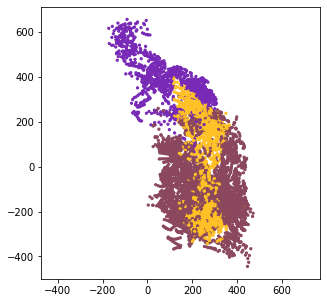

In [8]:
origin = np.mean([embryo.final[c] for c in embryo.all_cells if embryo.tissue[c] in [30, 31]], axis=0)
origin = np.hstack([origin, 80])
angles = np.array([-5., 5., 0.])
points_to_plot = embryo.plot_slice(angles, color_map=colors_paper, origin=origin, thickness=20,
                                   tissues=[18, 30, 31], nb_interp=5) 

### Gene colors

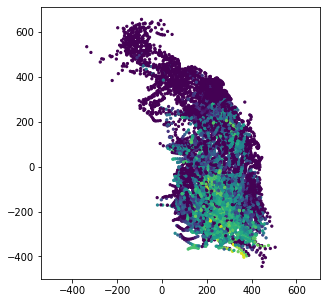

In [9]:
origin = np.mean([embryo.final[c] for c in embryo.all_cells if embryo.tissue[c] in [30, 31]], axis=0)
origin = np.hstack([origin, 80])
angles = np.array([-5., 5., 0.])
points_to_plot = embryo.plot_slice(angles, colors_paper, origin=origin, thickness=30, gene='T',
                                   tissues=[18, 30, 31], nb_interp=5, output_path='test.pdf')

### 2 Genes colors

Explanation of the 2 colors parameters:

`gene`: can be a single gene (as above) or a list of TWO genes as below

The color combinations availables are:
- Red and Cyan
- Green and Magenta
- Blue and Yellow

The parameter `main_bi_color` allows to choose one of these 3 combinations. `main_bi_color` can have 3 different values: `r`, `g` or `b` respectively referring to red, green and blue the first color of each color combination.

Moreover, 4 different parameters exists to define the upper and lower bounds of the gene expression values:
- `min_g1`: minimum value for the first gene of the list
- `min_g2`: minimum value for the second gene of the list
- `max_g1`: maximum value for the first gene of the list
- `max_g2`: maximum value for the second gene of the list

By default, if no value is provided (or `None`) these values are computed as the bottom and top 2 percent of the respective gene expression distributions.

To look at the color scale for bi-color plots, one can give the path to the image where the scale will be saved using the parameter `path_scale`. For example `path_scale='path/to/folder/scale.pdf'`


Finally, some parameters can be called to change the properties of the scatter plot, some are called in the example bellow:
- `alpha`: sets the transparency (0 being fully transparent, 1 being fully opaque)
- `linewidth`: width of the line around the markers
- `s`: size of the markers

All the possible parameters for the scatter plot can be found [there](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter).

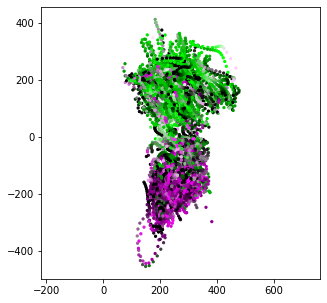

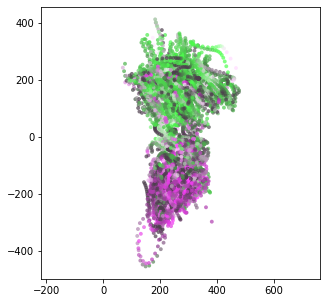

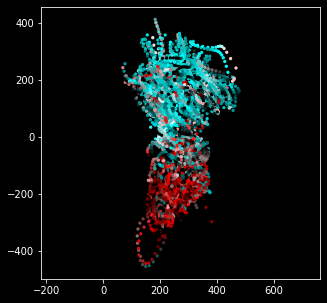

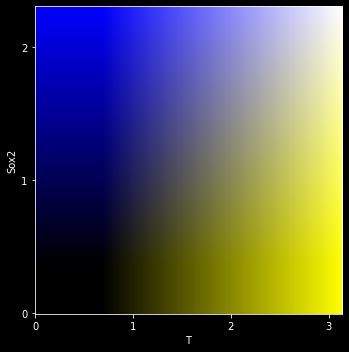

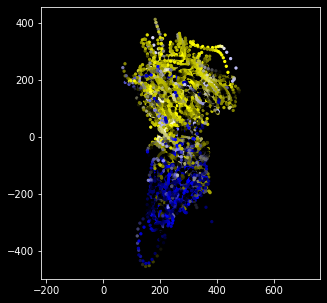

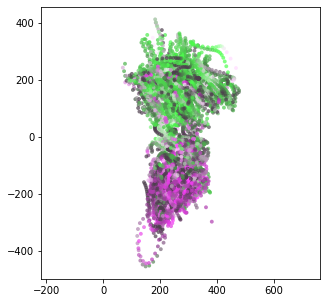

In [10]:
origin = np.mean([embryo.final[c] for c in embryo.all_cells if embryo.tissue[c] in [30, 31]], axis=0)
origin = np.hstack([origin, 50])
angles = np.array([180, 0., 0.])

# Use the line below before a plot to plot it with dark background
# When using this command line you need to ident the line below
# with plt.style.context('dark_background'):

# Basic plot
points_to_plot = embryo.plot_slice(angles, colors_paper, origin=origin, thickness=50,
                                   gene=['Sox2', 'T'], tissues=[31], nb_interp=5)

# Reducing the min and max values to make the plot less dark
# Changing the alpha to .7, the linewidth to 0 and the dot size to 15
points_to_plot = embryo.plot_slice(angles, colors_paper, origin=origin, thickness=50,
                                   gene=['Sox2', 'T'], tissues=[31], nb_interp=5,
                                   alpha=.7, linewidth=0, main_bi_color='g', s=15, min_g1=-1, min_g2=-1)

# Example changing the main color to red and using a black background
with plt.style.context('dark_background'):
    points_to_plot = embryo.plot_slice(angles, colors_paper, origin=origin, thickness=50,
                                       gene=['T', 'Sox2'], tissues=[31], nb_interp=5,
                                       main_bi_color='r')

# Example with the scale (parameter `path_scale`)
# together with change of the min_g1 and min_g2 to show the difference
# Moreover, because the line is still indented (shifted to the right),
# the dark background is still active
    points_to_plot = embryo.plot_slice(angles, colors_paper, origin=origin, thickness=50,
                                       gene=['T', 'Sox2'], tissues=[31], nb_interp=5,
                                       main_bi_color='b', path_scale='test.pdf', min_g1=.5, min_g2=.5)
    
# Back to normal indentation => back to white background
points_to_plot = embryo.plot_slice(angles, colors_paper, origin=origin, thickness=50,
                                   gene=['Sox2', 'T'], tissues=[31], nb_interp=5,
                                   alpha=.7, linewidth=0, main_bi_color='g', s=15, min_g1=-1, min_g2=-1)

## Saving the slice as a .ply
### With tissue colors

In [11]:
origin = np.mean([embryo.final[c] for c in embryo.all_cells if embryo.tissue[c] in [30, 31]], axis=0)
origin = np.hstack([origin, 80])
angles = np.array([-5., 5., 0.])
points_to_plot = embryo.ply_slice('out/slice.ply', angles, colors_paper, origin=origin,
                                  tissues_colored=[18, 30, 31],
                                  tissues=[18, 21, 30, 31, 34], nb_interp=5)

### With gene color

In [12]:
origin = np.mean([embryo.final[c] for c in embryo.all_cells if embryo.tissue[c] in [30, 31]], axis=0)
origin = np.hstack([origin, 80])
angles = np.array([-5., 5., 0.])
points_to_plot = embryo.ply_slice('out/slice_genes.ply', angles, colors_paper, origin=origin,
                                  tissues_colored=[18, 30, 31], gene='T',
                                  tissues=[18, 30, 31], nb_interp=5)

## Saving slice as h5ad

### With interpolated slices but only a subset of genes

In [14]:
origin = np.mean([embryo.final[c] for c in embryo.all_cells if embryo.tissue[c] in [30, 31]], axis=0)
origin = np.hstack([origin, 80])
angles = np.array([-5., 5., 0.])
points_to_plot = embryo.anndata_slice('out/slice.h5ad', angles,
                                      gene_list=genes_of_interest, origin=origin,
                                      tissues=[18, 21, 30, 31, 34])

/home/guignard/miniconda3/envs/sc3D/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/guignard/miniconda3/envs/sc3D/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted.id' as categorical


### Without interplated slices but with all genes

In [15]:
origin = np.mean([embryo.final[c] for c in embryo.all_cells if embryo.tissue[c] in [30, 31]], axis=0)
origin = np.hstack([origin, 80])
angles = np.array([-5., 5., 0.])
embryo.anndata_no_extra('out/all.h5ad', angles, origin=origin)

# Bonus: How to run multiple parameters at once:

In [16]:
# Tissues to plot in the pointcloud
tissues_to_plot = [18, 21, 30, 31, 34]
th_to_test = [.05, .1, .15, .2]

for test_outlier_th in th_to_test[:1]:
    # Load and reconstruct
    embryo = Embryo(data_path, tissues_to_ignore, corres_tissues, tissue_weight=tissue_weight,
                    xy_resolution=xy_resolution, genes_of_interest=genes_of_interest,
                    nb_CS_begin_ignore=nb_CS_begin_ignore, nb_CS_end_ignore=nb_CS_end_ignore)
    embryo.removing_spatial_outliers(th=test_outlier_th)
    embryo.set_zpos()
    embryo.reconstruct_intermediate(embryo, th_d=th_d, genes=genes_of_interest)
    
    # Writing the point cloud
    points, colors = embryo.produce_em(nb_interp, tissues_to_plot)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector([colors_paper[ci] for ci in colors])

    # Make sure to have created the folder test-outlier-th before
    o3d.io.write_point_cloud(f"out/th_{th_to_test}.ply", pcd)